## Skorch Random Hill Climbing Module
tpham328

Source: https://github.com/jlm429/pyperch/blob/master/notebooks


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.rhc_nn import RHCModule  
import matplotlib.pyplot as plt
from skorch.callbacks import EpochScoring 
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
data = pd.read_csv("winequality-white.csv")
print("Successfully Imported Data!")

data.head()
print(data.shape)

Successfully Imported Data!
(4898, 12)


In [3]:
X = data.drop(columns = 'quality')

original_Y = data['quality']
def class_quality(value):
    if value <= 5:
        return 0
    elif value == 6:
        return 1
    elif value >= 7:
        return 2

Y = original_Y.apply(class_quality)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


Y.value_counts(0)

quality
1    2198
0    1640
2    1060
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=328)
print(Y_train.value_counts(0))
print(Y_test.value_counts(0))

quality
1    1748
0    1336
2     834
Name: count, dtype: int64
quality
1    450
0    304
2    226
Name: count, dtype: int64


In [5]:
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

In [6]:

net = NeuralNetClassifier(
    module=RHCModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    module__step_size=.05,
    max_epochs=5000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda'
)

## train_step_single override - add RHC training step and disable backprop 

In [7]:
RHCModule.register_rhc_training_step()

In [34]:
# fit data
net.fit(X_train, Y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RHCModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=200, bias=True)
      (1-2): 2 x Linear(in_features=200, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=3, bias=True)
    )
  ),
)

## Plot learning curves

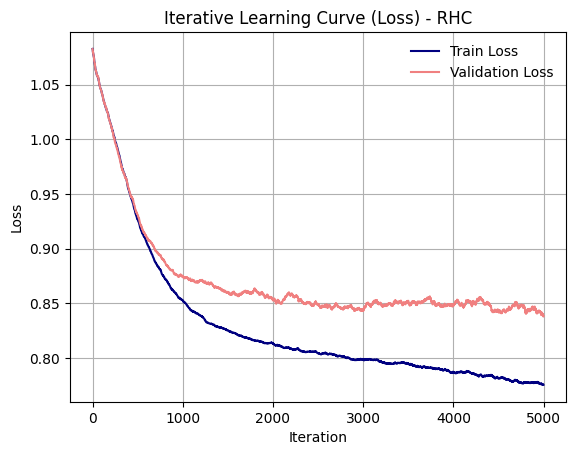

In [35]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) - RHC")
plt.grid(visible=True)
plt.legend(frameon=False)

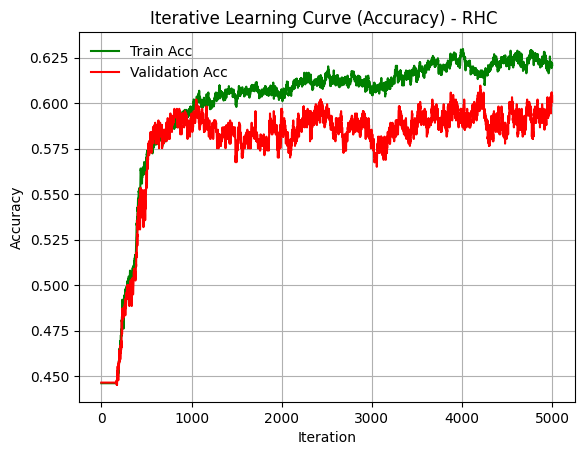

In [36]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='green')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='red')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy) - RHC ")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

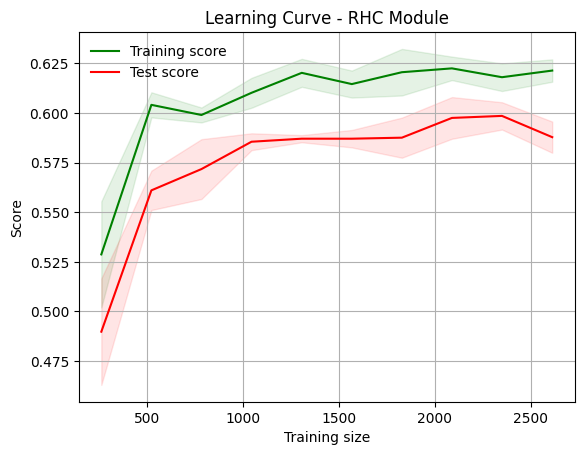

In [8]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='green')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='red')
plt.title("Learning Curve - RHC Module")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn grid search with RO

In [38]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [11],
    'module__output_dim': [3],
    'module__step_size': [0.1],
}

grid_search_params = {
    'max_epochs': [50,100],
    'module__hidden_units': [100, 200],
    'module__hidden_layers': [1, 2],
    **default_params,
}

gs = GridSearchCV(net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, Y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1; total time=  14.2s
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1; total time=  19.8s
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1; total time=  20.8s
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=200, module__input_dim=11, module__output_dim=3, module__step_size=0.1; total time=  27.9s
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=200, module__input_dim=11, module__output_dim=3, module__step_size=0.1; total time=  24.3s
[CV] END max_epochs=50, module__hidden_layers=1, module__hidden_units=200, module__input_dim=11, module__output_dim=3, module__step_siz

In [41]:
net = NeuralNetClassifier(
    module=RHCModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    module__step_size=.05,
    max_epochs=800,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda'
)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

net.fit(X_train, Y_train)

# Predict on test data
Y_pred = net.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1 score for each class
f1 = f1_score(Y_test, Y_pred, average=None)
print(f'F1 Score (per class): {f1}')

# Compute and print the classification report
report = classification_report(Y_test, Y_pred, target_names=['low', 'medium', 'high'])
print(report)

C:\Users\trung\AppData\Local\Temp\ipykernel_264972\1789874708.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\trung\AppData\Local\Temp\ipykernel_264972\1789874708.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long)


Accuracy: 0.5653
F1 Score (per class): [0.60377358 0.62274368 0.24535316]
              precision    recall  f1-score   support

         low       0.63      0.58      0.60       304
      medium       0.52      0.77      0.62       450
        high       0.77      0.15      0.25       226

    accuracy                           0.57       980
   macro avg       0.64      0.50      0.49       980
weighted avg       0.61      0.57      0.53       980

